# **Deep Research with Bing Search**

This notebook demonstrates an agentic research workflow that leverages Azure AI services to conduct comprehensive web-based research on any topic. The workflow includes:

1. **Research Planning** - Breaking down complex queries into structured subtopics and targeted search queries
2. **Information Retrieval** - Using Bing Search API through Azure AI Services to gather relevant web content
3. **Content Analysis** - Summarizing search results and extracting key insights 
4. **Report Generation** - Creating detailed research reports with proper citations
5. **Peer Review** - Evaluating report quality and suggesting improvements until quality standards are met

The notebook orchestrates multiple specialized AI agents working together:
- PlannerAgent - Creates comprehensive research plans with subtopics and queries
- BingSearchAgent - Retrieves relevant search results from the web
- SummaryAgent - Extracts key insights from retrieved content
- ResearchAgent - Compiles findings into structured research reports
- PeerReviewAgent - Provides quality feedback in a continuous improvement loop

Built with Azure OpenAI, Azure AI Projects, and the OpenAI Agents SDK.

## Environment Setup

First, we'll set up our environment by importing necessary libraries and loading environment variables from a .env file. These environment variables contain configuration details such as API keys and endpoints for the Azure OpenAI and Bing Search services.

In [1]:
import dotenv
dotenv.load_dotenv(".env", override=True)

True

## Agent Configuration

The research workflow is powered by Azure AI Agents, with Semantic Kernel serving as the orchestration framework to coordinate between different specialized agents.

All agents are created using Azure AI Projects and are orchestrated through Semantic Kernel to handle various research tasks including web search capabilities and specialized analysis.

Let's configure each agent with their specific instructions and capabilities using the Semantic Kernel framework.

### Azure AI Foundry Connections

First, we'll establish connections to Azure AI Projects, which provides the infrastructure for our Bing Search agent.

In [2]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential
import os

project_client = AIProjectClient(
    credential=DefaultAzureCredential(),
    endpoint=os.getenv("PROJECT_ENDPOINT")
)

The following cell will **create the Azure AI Agents**, so you only need to run this cell **once**.

In [3]:
# from common.create_azure_ai_agents import (
#     create_bing_search_agent,
#     create_research_plan_agent,
#     create_summary_agent,
#     create_research_report_agent,
#     create_peer_review_agent
# )

# planner_agent = create_research_plan_agent(project_client=project_client)
# bing_search_agent = create_bing_search_agent(project_client=project_client)
# summary_agent = create_summary_agent(project_client=project_client)
# research_agent = create_research_report_agent(project_client=project_client)
# peer_review_agent = create_peer_review_agent(project_client=project_client)

Fetch agents from Ai Foundry

In [4]:
planner_agent = project_client.agents.get_agent(agent_id=os.getenv("PlannerAgentID"))
bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("BingSearchAgentID"))
summary_agent = project_client.agents.get_agent(agent_id=os.getenv("SummaryAgentID"))
research_agent = project_client.agents.get_agent(agent_id=os.getenv("ResearchAgentID"))
peer_review_agent = project_client.agents.get_agent(agent_id=os.getenv("PeerReviewAgentID"))

Update their system messages

In [5]:
from common.update_instructions import (
    update_planner_instructions,
    update_bing_instructions,
    update_summary_instructions,
    update_research_instructions,
    update_peer_review_instructions
)

planner_agent = update_planner_instructions(agent=planner_agent)
bing_search_agent = update_bing_instructions(agent=bing_search_agent)
summary_agent = update_summary_instructions(agent=summary_agent)
research_agent = update_research_instructions(agent=research_agent)
peer_review_agent = update_peer_review_instructions(agent=peer_review_agent)

## Research Workflow

Our system uses specialized AI agents to transform a user query into a comprehensive research report through these steps:

### Process Flow

1. **User Query** → User submits research topic or question
2. **Planning** → PlannerAgent develops structured research plan with objectives and subtopics
3. **Information Retrieval** → BingSearchAgent executes targeted web searches for each area
4. **Analysis** → SummaryAgent processes results, extracting key insights while preserving technical details
5. **Synthesis** → ResearchAgent creates well-structured report with proper citations
6. **Quality Control** → PeerReviewAgent evaluates report for completeness, clarity, and evidence
7. **Revision** → If needed, research report undergoes improvement cycles based on feedback
8. **Delivery** → Final comprehensive, high-quality report delivered to user

This collaborative approach combines the strengths of different specialized agents to produce thorough, evidence-based research that meets predefined quality standards.

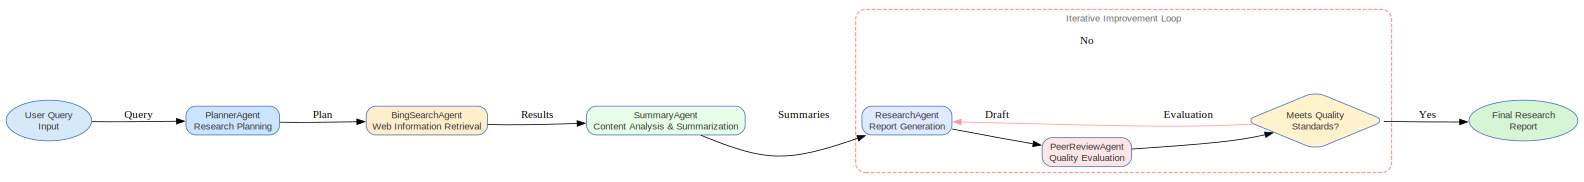

In [6]:
from common.helper import create_research_workflow_diagram

# This will generate research_workflow_diagram.png and return the Digraph object
workflow_diagram = create_research_workflow_diagram()
workflow_diagram

Let's start with a sample research query.

In [7]:
# user_query="What big industries will AI have the most affected on?"
user_query="What are the differences between classical machine learning, deep learning and generative AI?"

### Step 1: Research Planning

The PlannerAgent analyzes the research query and creates a structured plan with:

- Research objective - A clear statement of what the research aims to accomplish
- Subtopics - Key areas to explore for comprehensive coverage
- Search queries - Specific queries for each subtopic to gather relevant information
- Success criteria - Metrics to determine research completeness
- Related topics - Additional areas that may provide valuable context

In [8]:
from azure.ai.agents.models import MessageRole
from common.data_models import ResearchPlan
from common.utils_ai_agents import (
    add_user_message_to_thread,
    invoke_agent
)
import json

# create a thread and add the user message
thread = project_client.agents.threads.create()
add_user_message_to_thread(project_client, thread.id, user_query)

# invoke the planner agent to create a research plan
planner_agent_output, thread = invoke_agent(
    project_client=project_client,
    thread=thread,
    agent=planner_agent
)

# parse the output to a ResearchPlan object
plan_data = json.loads(planner_agent_output)
plan = ResearchPlan(**plan_data)

# delete the thread
project_client.agents.threads.delete(thread_id=thread.id)

In [9]:
plan.research_tasks[0].search_queries

['definition of classical machine learning',
 'what is deep learning in AI',
 'generative AI definition and explanation',
 'core concepts of classical machine learning vs deep learning vs generative AI',
 'overview of machine learning paradigms']

### Step 2: Information Retrieval

The BingSearchAgent executes web searches for each query in our research plan. For each subtopic:

1. We send multiple search queries to gather diverse perspectives
2. The agent returns structured search results with titles, full_text, and URLs
3. Results are organized by subtopic for further processing

This step leverages Azure AI Projects with Bing Search integration to ensure up-to-date information from across the web.

In [10]:
from tqdm import tqdm
from common.utils_search import extract_agent_response_and_urls

search_results = []

for subtopic in tqdm(plan.research_tasks, desc="Subtopics"):
    subtopic_results = {"subtopic": subtopic.subtopic, "queries": []}

    for query in tqdm(subtopic.search_queries, desc=f"Queries ({subtopic.subtopic})", leave=False):
        formatted_query = f"""
        Research the following query: {query}
        This is related to subtopic: {subtopic.subtopic}
        Please provide the information and cite your sources using the available tools.
        """
        try:
            thread = project_client.agents.threads.create()
            add_user_message_to_thread(project_client, thread.id, formatted_query)

            bing_search_agent_output, thread = invoke_agent(
                project_client=project_client,
                thread=thread,
                agent=bing_search_agent
            )

            agent_response_text, extracted_urls = extract_agent_response_and_urls(project_client, thread.id, query)

            # Add to our results collection
            subtopic_results["queries"].append({
                "query": query,
                "agent_response": agent_response_text,
                "results": extracted_urls
            })

            # Delete the thread after processing
            project_client.agents.threads.delete(thread_id=thread.id)

        except Exception as e:
            print(f"An error occurred processing query '{query}': {e}")
            # Optionally add error information to results
            subtopic_results["queries"].append({
                "query": query,
                "results": [],
                "error": str(e)
            })

    search_results.append(subtopic_results)

Subtopics: 100%|██████████| 5/5 [04:13<00:00, 50.68s/it]


In [11]:
print(f"Planned total search queries: {sum(1 for task in plan.research_tasks for search_query in task.search_queries)}\n")
print(f"Actually total search queries: {sum(1 for task in search_results for result in task['queries'])}\n")

Planned total search queries: 25

Actually total search queries: 25



### Step 3: Content Analysis and Summarization

For each search result retrieved, the SummaryAgent:

1. Extracts key facts, statistics, and insights from the raw search content
2. Preserves important technical details, dates, and domain-specific terminology
3. Formats the summary with key insights and detailed paragraph explanations
4. Tracks citations for proper attribution in the final report

This step transforms raw search data into structured, information-rich summaries that will form the basis of our research report.

In [12]:
from common.utils_summary import collect_responses_and_citations

mapped_chunks = []

for subtopic_result in tqdm(search_results, desc="Summarizing subtopics"):
    all_agent_responses_for_subtopic, unique_citations_for_subtopic = collect_responses_and_citations(subtopic_result)

    # --- Summarize the combined agent responses ONCE per subtopic ---
    content_to_summarize = "\n\n---\n\n".join(all_agent_responses_for_subtopic)

    subtopic_summary = "No content found to summarize for this subtopic." # Default value
    if content_to_summarize:
        summary_prompt = f"Summarize the following information related to the subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}':\n\n{content_to_summarize}"
        try:
            thread = project_client.agents.threads.create()
            add_user_message_to_thread(project_client, thread.id, summary_prompt)
            # Invoke the summary agent to summarize the content
            summary_agent_output, thread = invoke_agent(
                project_client=project_client,
                thread=thread,
                agent=summary_agent
            )

            # run = project_client.agents.runs.create_and_process(thread_id=thread.id, agent_id=summary_agent.id)
            # subtopic_summary = get_last_message_by_role(project_client, thread.id, MessageRole.AGENT)
            subtopic_summary = summary_agent_output.strip()  # Ensure we get the text output
        except Exception as e:
            print(f"Error summarizing subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}': {e}")
            subtopic_summary = f"Error during summarization for subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}'. Details: {e}"
            # Depending on requirements, you might want to raise the exception, log it, or handle it differently

    # --- Convert set of tuples back to list of dictionaries (or Citation objects) ---
    citations_list = [
        {"title": title, "url": url}
        for title, url in unique_citations_for_subtopic
    ]

    # --- Append the consolidated result ---
    mapped_chunks.append({
        "subtopic": subtopic_result.get("subtopic", "Unknown Subtopic"), # Use .get for safety
        "summary": subtopic_summary,
        "citations": citations_list
    })

Summarizing subtopics: 100%|██████████| 5/5 [01:31<00:00, 18.29s/it]


### Step 4: Report Generation and Peer Review

In this final stage:

1. The ResearchAgent synthesizes all summarized content into a comprehensive report
2. The PeerReviewAgent evaluates the report based on completeness, clarity, evidence, and insight
3. If needed, the report is revised based on feedback
4. This cycle continues until quality standards are met

The final report is structured as a cohesive academic-style document with proper citations and a references section.

In [13]:
from common.data_models import ComprehensiveResearchReport, PeerReviewFeedback
from common.utils_ai_agents import add_user_message_to_thread

def loop_agents(project_client, agent_a, agent_b, initial_input, max_iterations=10):
    """
    Loop between two agents until agent B produces the target output.
    
    Args:
        agent_a: Function that takes input and returns output
        agent_b: Function that takes input and returns output
        initial_input: Starting input for agent A
        max_iterations: Safety limit to prevent infinite loops
    
    Returns:
        The final output from agent B, or None if max iterations reached
    """

    thread = project_client.agents.threads.create()
    add_user_message_to_thread(project_client, thread.id, initial_input)

    for it in range(max_iterations):        
        # Agent A processes the input
        a_output, thread = invoke_agent(
            project_client=project_client,
            thread=thread,
            agent=agent_a
        )
        
        # Agent B processes A's output
        b_output, thread = invoke_agent(
            project_client=project_client,
            thread=thread,
            agent=agent_b
        )

        b_output_json = json.loads(b_output)
        review = PeerReviewFeedback(**b_output_json)

        # Check if B produced the target output
        if review.is_satisfactory is not False:
            print(f"Target output reached after {it+1} iterations!")
            report_json = json.loads(a_output)
            final_report = ComprehensiveResearchReport(**report_json)

            # delete the thread
            project_client.agents.threads.delete(thread_id=thread.id)
            return final_report
        
        # Use B's output as input for the next iteration
        current_input = b_output

    print(f"Max iterations ({max_iterations}) reached without finding target output") 
    return None

In [14]:
import json
from common.utils_research import preprocess_research_data

research_input = preprocess_research_data(plan, mapped_chunks)
research_input_prompt = json.dumps(research_input, indent=2)

research_query = (
    "Create an exceptionally comprehensive, **paragraph-focused** and detailed research report "
    "using the following content. **Minimize bullet points** and ensure the final text resembles "
    "a cohesive, academic-style paper:\n\n"
    f"{research_input_prompt}\n\n"
    "As a final reminder, don't forget to include the citation list at the end of the report."
)

# Run the loop
final_report = loop_agents(
    project_client=project_client,
    agent_a=research_agent,
    agent_b=peer_review_agent,
    initial_input=research_query,
    max_iterations=10
)

Target output reached after 1 iterations!


In [15]:
from IPython.display import display, Markdown
display(Markdown(final_report.research_report))

# A Comprehensive Analysis of Classical Machine Learning, Deep Learning, and Generative AI: Definitions, Methodologies, Applications, and Future Directions

## Introduction

The field of artificial intelligence (AI) has undergone a remarkable transformation over the past several decades, evolving from early rule-based systems to sophisticated models capable of autonomous learning, perception, and even creative content generation. Central to this evolution are three major paradigms: classical machine learning, deep learning, and generative AI. Each of these approaches is defined by distinct theoretical foundations, methodological choices, and practical applications. As AI becomes increasingly embedded in the fabric of modern society—powering everything from medical diagnostics to autonomous vehicles and creative design—the need for a nuanced understanding of these paradigms, their differences, and their respective strengths and limitations has never been greater.

This report provides an authoritative, in-depth analysis of classical machine learning, deep learning, and generative AI. It begins by establishing clear definitions and core concepts, then delves into the methodologies and algorithms that underpin each approach. The discussion proceeds to a thorough examination of real-world applications and use cases, followed by a critical assessment of the strengths, limitations, and challenges unique to each paradigm. Finally, the report situates these technologies within their historical context and explores emerging trends that are likely to shape the future of AI. Throughout, the analysis is supported by quantitative data, comparative insights, and references to credible academic and industry sources.

## 1. Definitions and Core Concepts

The landscape of AI and machine learning is anchored in foundational definitions and conceptual frameworks that delineate the primary approaches for enabling machines to learn from data. At its core, machine learning (ML) is a subset of AI focused on developing algorithms that allow computers to identify patterns and make predictions or decisions based on data. Within this broad domain, classical machine learning, deep learning, and generative AI represent progressively more complex and capable methodologies, each with its own defining characteristics.

### 1.1 Classical Machine Learning

Classical machine learning refers to a suite of statistical and algorithmic techniques designed to extract patterns from structured data—datasets organized in rows and columns, where features are explicitly defined. The hallmark of classical ML is its reliance on manual feature engineering, a process in which domain experts identify and select the most relevant variables for analysis. Common algorithms include linear regression, logistic regression, decision trees, support vector machines (SVM), k-nearest neighbors (KNN), and naive Bayes classifiers. These models are typically favored for their interpretability, computational efficiency, and effectiveness on small to medium-sized datasets. Classical ML excels in tasks such as classification (assigning categories), regression (predicting continuous values), clustering (grouping similar data points), and anomaly detection (identifying outliers) [1][2][3].

### 1.2 Deep Learning

Deep learning is a specialized branch of machine learning that leverages artificial neural networks (ANNs) with multiple layers—hence the term "deep"—to automatically learn hierarchical representations from data. Inspired by the structure and function of the human brain, deep learning models consist of interconnected layers of artificial neurons that process information through weighted connections. Unlike classical ML, deep learning obviates the need for manual feature engineering; instead, it autonomously discovers salient features directly from raw, unstructured data such as images, audio, and text. Training is typically accomplished via backpropagation, an iterative process that adjusts network weights to minimize prediction errors. Deep learning's success is closely tied to the availability of large, labeled datasets and significant computational resources, enabling breakthroughs in fields like computer vision, natural language processing, and speech recognition [2][3][4][5].

### 1.3 Generative AI

Generative AI stands at the intersection of deep learning and creative content generation. It encompasses a class of models designed to produce new, original data by learning the underlying patterns and distributions present in existing datasets. The technological foundations of generative AI are advanced deep learning architectures such as Generative Adversarial Networks (GANs), Variational Autoencoders (VAEs), and Large Language Models (LLMs) like GPT. These models are capable of synthesizing realistic images, coherent text, music, and even code by sampling from learned data distributions. Generative AI is revolutionizing industries by enabling tasks such as data augmentation, creative content synthesis, simulation, and more [1][4][5][6].

### 1.4 Learning Paradigms and Fundamental Concepts

Underlying all these approaches are various machine learning paradigms that define how algorithms interact with data:

- **Supervised Learning:** Models learn to map inputs to outputs using labeled datasets. Examples include image classification and sales forecasting.
- **Unsupervised Learning:** Models identify patterns or groupings in unlabeled data, as seen in clustering and dimensionality reduction.
- **Semi-Supervised Learning:** Combines a small amount of labeled data with a large pool of unlabeled data to improve learning accuracy.
- **Reinforcement Learning:** Agents learn optimal actions through trial-and-error interactions with an environment, guided by rewards and penalties.
- **Self-Supervised Learning:** Models generate their own supervisory signals from the data, a technique gaining traction in natural language and computer vision.
- **Transfer Learning:** Models trained on one task are adapted to perform related tasks, enhancing efficiency when data is scarce.

Other core concepts traverse these paradigms, including models (algorithmic structures for prediction), features (input variables), labels (ground truth targets), loss functions (measuring prediction error), training (the process of learning from data), and generalization (the ability to perform well on unseen data) [3][4][7].

In summary, the definitions and core concepts of classical machine learning, deep learning, and generative AI reflect a continuum of increasing model complexity, automation, and capability. Each paradigm offers distinct advantages for different data types, tasks, and industrial requirements, forming the backbone of contemporary AI advancement.

## 2. Methodologies and Algorithms

The methodologies and algorithms that underpin classical machine learning, deep learning, and generative AI are the engines driving modern artificial intelligence. While these paradigms share foundational roots, they diverge significantly in their technical strategies, data requirements, and problem-solving approaches.

### 2.1 Classical Machine Learning Methodologies and Algorithms

Classical machine learning methodologies are characterized by their focus on structured, tabular data and their reliance on interpretable, resource-efficient models. The process typically begins with manual feature engineering, where domain expertise is used to extract and select relevant input features. The most prominent algorithms include:

- **Linear Regression:** Used for predicting continuous outcomes, fitting a linear equation to minimize squared error.
- **Logistic Regression:** Applied to binary classification tasks, modeling the probability of class membership using the logistic function.
- **Decision Trees:** Hierarchical models that split data based on feature values, suitable for both classification and regression.
- **Random Forests:** Ensembles of decision trees that improve robustness and reduce overfitting by averaging multiple tree predictions.
- **Support Vector Machines (SVM):** Optimization-based models that find the maximum margin hyperplane separating classes, supporting both linear and non-linear boundaries via kernel tricks.
- **k-Nearest Neighbors (k-NN):** Non-parametric classifiers that assign labels based on the majority vote of nearest neighbors in feature space.
- **Naive Bayes:** Probabilistic classifiers leveraging Bayes’ theorem, assuming feature independence.
- **Gradient Boosting Machines (GBM):** Sequentially adds models to correct predecessor errors, optimizing loss functions via gradient descent.
- **Principal Component Analysis (PCA):** Unsupervised dimensionality reduction technique that projects data into lower-dimensional spaces while preserving variance.
- **Clustering (e.g., k-Means):** Unsupervised grouping of data points by similarity.

These algorithms are particularly effective for small to moderate-sized datasets and are preferred when model interpretability is crucial. They are widely used as baselines or starting points in domains such as finance, healthcare, and marketing [2][3][7].

### 2.2 Deep Learning Methodologies and Algorithms

Deep learning methodologies build on neural network architectures with multiple computational layers, enabling the discovery of intricate patterns in unstructured data. The defining feature of deep learning is hierarchical feature learning, where features are learned directly from data rather than manually engineered. Key architectures include:

- **Feedforward Neural Networks (FNNs):** The simplest deep models, processing inputs in a single direction through fully connected layers.
- **Convolutional Neural Networks (CNNs):** Designed for grid-structured data such as images, employing convolutional and pooling layers to extract spatial features.
- **Recurrent Neural Networks (RNNs), LSTMs, GRUs:** Suited for sequential data like speech and text, maintaining temporal context through loops and advanced memory mechanisms.
- **Transformers:** Utilize self-attention mechanisms to process sequences in parallel, capturing global relationships between input elements. Architectures like BERT and GPT have set new benchmarks in natural language processing.
- **Autoencoders:** Encoder-decoder networks used for non-linear dimensionality reduction and feature learning.
- **Generative Adversarial Networks (GANs):** Consist of generator and discriminator networks engaged in adversarial training, foundational for generative AI.

Training deep networks involves algorithms such as backpropagation for gradient computation, dropout for regularization, batch normalization for stabilizing learning, and transfer learning for adapting pre-trained models to new tasks. Attention mechanisms further enhance sequence-to-sequence models by focusing processing on relevant input segments [3][4][8].

Deep learning’s automatic feature discovery and scalability make it indispensable for end-to-end learning in complex, data-rich environments. However, these strengths are counterbalanced by increased opacity, higher computational demands, and a dependency on large labeled datasets.

### 2.3 Generative AI Methodologies and Algorithms

Generative AI methodologies are centered on learning the underlying data distribution to produce new, synthetic data samples. The most advanced generative models are built upon deep learning architectures and employ probabilistic modeling and adversarial training. Key algorithms include:

- **Generative Adversarial Networks (GANs):** Implement a minimax game between a generator (producing synthetic data) and a discriminator (distinguishing real from fake data), resulting in highly realistic outputs.
- **Variational Autoencoders (VAEs):** Probabilistic models that encode data into a latent space and decode it back, enabling the sampling of new data points.
- **Transformer-based Models (LLMs):** Large Language Models like GPT and BERT, powered by transformer architectures, excel at generating coherent language and other modalities.
- **Diffusion Models:** Stochastic processes that iteratively denoise random noise into sample data, achieving impressive results in image generation.
- **Agentic Retrieval:** An emerging methodology that combines conversation history, external data retrieval, and planning by LLMs to provide context-aware, factually grounded responses [9][10][11].

These methods often involve learning joint or marginal probability distributions and employ complex optimization techniques, including adversarial (game-theoretic) and probabilistic training. The result is a class of models capable of generating high-fidelity content that closely mimics real-world data [4][5][6].

### 2.4 Comparative Methodological Synthesis

While classical ML, deep learning, and generative AI share a common lineage, their methodological choices reflect divergent priorities and technical requirements. Classical ML prioritizes interpretability and efficiency, deep learning emphasizes scalability and automatic feature extraction, and generative AI focuses on creative synthesis and probabilistic modeling. The choice of methodology is thus tightly coupled with the problem domain, data type, desired output, and operational constraints. As the field advances, hybrid models and innovative retrieval-augmented generation techniques are pushing the boundaries of what AI can achieve [9][10].

## 3. Applications and Use Cases

The practical impact of classical machine learning, deep learning, and generative AI is most evident in their diverse applications across industries. Each paradigm demonstrates unique strengths based on data type, interpretability, computational requirements, and desired outcomes.

### 3.1 Classical Machine Learning: Structured Data and Interpretability

Classical machine learning algorithms are foundational in real-world data analysis, particularly for structured or tabular datasets. Their mathematical simplicity, computational efficiency, and ease of interpretation make them ideal for tasks where transparency is essential and data scales are modest.

In healthcare, classical ML models such as logistic regression are widely used for disease diagnosis and prognosis, leveraging patient records to predict the onset of conditions like diabetes or cardiovascular disease. SVMs and decision trees support medical image analysis by distinguishing between benign and malignant findings using extracted features. In finance and banking, classical ML underpins credit scoring, loan risk assessment, and fraud detection, often using clustering or anomaly detection on transaction data. The interpretability of these models is critical for regulatory compliance and decision justification [12][13].

Marketing and customer analytics benefit from techniques like k-means clustering for customer segmentation, while churn prediction and targeted advertising often utilize logistic regression and naive Bayes classifiers. Manufacturing relies on regression models for predictive maintenance and quality control, supporting process optimization and cost reduction. Even in natural language processing, classical models like naive Bayes remain effective for spam detection and basic sentiment analysis [13][14].

Despite the rise of more complex systems, classical algorithms retain their relevance due to their robustness on smaller, well-structured datasets and when results must be explainable—traits valuable in healthcare, finance, and regulated industries.

### 3.2 Deep Learning: Unstructured Data and Complex Pattern Recognition

Deep learning excels in processing unstructured, high-dimensional data such as images, audio, and natural language. Models like convolutional neural networks (CNNs) and recurrent neural networks (RNNs), supported by advances in GPU computing, have enabled transformational applications.

In healthcare, deep learning is pivotal for medical imaging diagnostics—CNNs surpass classical methods in tasks like tumor detection in radiology images, providing higher accuracy by automatically learning intricate patterns. The automotive sector leverages deep learning for autonomous driving, where CNNs, LSTMs, and reinforcement learning work together for object detection, environmental perception, and real-time decision-making. Advanced driver-assistance systems (ADAS) similarly benefit from these models to enhance safety [15][16].

Finance applies deep learning for high-frequency trading algorithms, complex fraud detection, and personalized financial advisory chatbots. Retail and e-commerce use deep neural networks for personalized product recommendations, demand forecasting, visual search, and sentiment analysis from customer reviews. Agricultural technology employs deep learning for crop yield prediction, pest and disease detection, and resource optimization using satellite imagery [17][18].

Manufacturing embraces deep learning for automated visual inspection and predictive maintenance, processing multi-modal sensor data to foresee breakdowns. Deep learning is also foundational for advanced technology applications such as speech-to-text in voice assistants, language translation, and image/video recognition platforms vital for content moderation and media tagging [19][20].

### 3.3 Generative AI: Automated Creativity and Synthetic Data

Generative AI, powered by large language models (LLMs) and advanced architectures like diffusion models and GANs, is reshaping industries by automating content generation and augmenting human creativity. These models synthesize new data that closely mimics real-world examples, going beyond prediction to creation.

In content creation, LLMs generate articles, marketing copy, emails, reports, and multimedia content, drastically reducing the time and effort required for design, entertainment, and advertising. AI-based copilots assist in code generation, accelerating software development and reducing manual errors. Healthcare benefits from generative models for drug discovery, synthetic data generation for research privacy, and auto-generating radiology reports or summarizing patient histories [21][22].

Marketing and advertising harness generative AI for hyper-personalized campaigns, compelling social media posts, and dynamic product descriptions. Customer service is enhanced by virtual assistants and chatbots that provide real-time, context-aware support. Design and creative industries employ generative tools for ideating product designs, visual concepts, and even generating original artworks and music tracks [23][24].

Emerging edge computing and IoT applications deploy generative AI models for real-time inference and privacy-preserving solutions directly on devices, minimizing latency and reducing reliance on centralized cloud infrastructure. For data augmentation and retrieval, generative AI creates synthetic training data to enhance model robustness and employs Retrieval Augmented Generation (RAG) for more effective search and summarization tasks [25].

### 3.4 Comparative Nuances and Selection Criteria

A comparative view crystallizes the application boundaries: classical machine learning is best suited to smaller, structured datasets and scenarios demanding transparency; deep learning takes precedence for unstructured, high-dimensional data and complex pattern extraction; and generative AI is the technology of choice for content generation, simulation, and augmentation. The selection of an AI approach depends on input data type, scale, interpretability requirements, problem complexity, and whether the core need is prediction/classification or creative synthesis [12][13][16].

In summary, while emerging techniques like generative AI are revolutionizing automation and creativity, classical ML and deep learning remain indispensable for structured prediction tasks and complex pattern recognition, respectively. A nuanced understanding of application requirements and technology strengths ensures the optimal approach, maximizing operational impact across sectors.

## 4. Strengths, Limitations, and Challenges

Each paradigm in the machine learning spectrum offers unique operational strengths and faces domain-specific challenges. Understanding these trade-offs is essential for responsible AI adoption and future research.

### 4.1 Classical Machine Learning

Classical machine learning models are lauded for their high interpretability, efficiency, and low data requirements. Their transparent nature is crucial in domains like healthcare and finance, where explainability supports regulatory compliance and user trust. These models are computationally efficient and can often be trained quickly, even on small or moderate-sized datasets. Their well-established statistical underpinnings contribute to predictable behavior and reliability in structured data environments [1][2][3].

However, classical approaches demand extensive manual feature engineering, relying on domain expertise to transform raw inputs into model-ready formats. This manual process can become a bottleneck as datasets grow in size and complexity. Scalability is a core challenge; classical methods may plateau in performance when confronted with high-dimensional or massive datasets, or when faced with unstructured data such as images or natural language. Their reduced flexibility limits their ability to model complex, nonlinear relationships, and they may be sensitive to outliers or noisy inputs, undermining robustness in real-world applications [3][7].

### 4.2 Deep Learning

Deep learning has transformed capabilities in handling unstructured data by automating feature extraction and achieving unprecedented accuracy in tasks such as image classification, natural language processing, and speech recognition. Its scalability enables performance gains as dataset sizes and computational power increase. However, these benefits come at the cost of immense data and computing requirements: deep learning models generally require millions of labeled examples and powerful hardware for both training and inference. This resource intensity can be a barrier for smaller organizations or data-scarce domains [4][5][8].

Deep learning models are often criticized for their "black box" nature, with limited interpretability relative to classical ML. This complicates their adoption in sensitive or regulated applications. They are also prone to overfitting, especially when datasets are unbalanced or not representative, and are susceptible to perpetuating biases found in training data. Robustness issues persist, as adversarial attacks—minor, often imperceptible modifications to input data—can yield drastically incorrect predictions. The substantial energy consumption required for model training and deployment raises environmental sustainability concerns, which are increasingly salient as models scale [8][26].

### 4.3 Generative AI

Generative AI represents the frontier of machine learning’s creative and augmentative potential, capable of synthesizing novel content and augmenting existing datasets. Its automated feature learning offers versatility in tasks such as summarization, translation, and creative design. However, generative AI also poses formidable risks. The propagation of biases present in training data can yield biased, unfair, or inappropriate outputs, reinforcing stereotypes or systemic inequities. The ease with which convincing synthetic content can be produced propagates misinformation, fraud, and security vulnerabilities [27][28][29].

Legal and ethical conundrums arise as models generate outputs that may infringe on intellectual property or disclose sensitive data, challenging current frameworks around content authenticity and copyright. Quality control remains problematic, as generative models occasionally produce nonsensical or inaccurate content, necessitating robust validation and monitoring. The “black box” challenge is even more pronounced in generative systems, intensifying regulatory and compliance headaches. Substantial computational and financial resources are required for both training and deploying these architectures, raising concerns about power consumption and environmental impact. Integration into existing digital infrastructures and measuring the trustworthiness of outputs are further challenges [27][28][29].

### 4.4 Comparative Analysis

A comparative analysis reveals clear trade-offs: classical ML offers efficiency and transparency on structured data but lacks adaptability; deep learning scales for complexity but at the cost of resource intensity and interpretability; and generative AI unlocks creative, open-ended applications but invites new fronts of ethical concern, security risk, and integration hurdles. Ongoing research aims to bridge the interpretability-resource utility gap, improve robustness and fairness, and develop regulatory standards that match the rapid technological pace [27][28][29].

## 5. Historical Evolution and Future Trends

The development of machine learning and AI reflects a trajectory spanning over seven decades, with each era characterized by distinct technological and conceptual advances. Understanding this historical context is essential for appreciating current capabilities and anticipating future directions.

### 5.1 Historical Evolution

#### Early Foundations (1950s–1960s)

Machine learning’s origin is rooted in post-war AI research, where scientists explored whether computers could learn from data. Early programs, such as those playing checkers and chess, demonstrated machines improving performance through experience. Statistically inspired methods, notably Bayesian inference, enabled probabilistic learning and decision-making. These theoretical foundations, combined with advances in computer science, set the stage for the field [30][31][32].

#### Classical Machine Learning and Growth (1970s–1990s)

As computational power improved, the 1970s and 1980s saw the refinement of foundational ML algorithms, including decision trees, single-layer neural networks, and the pioneering backpropagation algorithm. The 1990s witnessed the rise of support vector machines, k-nearest neighbors, and ensemble methods like bagging and boosting. However, these classical models were critically dependent on expert-driven feature engineering [33][34][35].

#### The Deep Learning Era (2000s–Present)

The 21st century marked a paradigm shift as large-scale digital datasets and GPU acceleration enabled the viable training of deep neural networks. The 2012 introduction of AlexNet, a deep convolutional neural network for image recognition, catalyzed industry-wide adoption of deep learning. Systems like CNNs for vision, RNNs for sequential data, and transformers for language processing advanced the state-of-the-art in numerous domains. The move from manual to automated feature extraction distinguished this era, enabling superior performance on high-dimensional, unstructured tasks [36][37][38].

#### Rise of Generative AI (2014–Present)

The advent of generative models marked a major leap. GANs in 2014 unlocked the ability of AI systems to synthesize realistic images, sounds, and text. Transformer architectures (e.g., BERT, GPT, DALL-E) in the late 2010s further pushed AI’s creative boundaries, demonstrating capacity to generate coherent, original content by leveraging massive parallel architectures and extensive datasets. Generative AI not only automates creative work but also enables tasks such as AI-powered search engine overviews, real-time intelligent dialogue, and personalized content creation [39][40][41].

### 5.2 Future Trends

#### Explainability, Ethics, and Trust

As ML and AI models grow in complexity and capability, the need for transparency, interpretability, and fairness intensifies. Ensuring AI systems can be trusted—by mitigating bias, providing robust explanations, and adhering to ethical norms—has become a central research imperative. Regulatory frameworks to govern AI development and deployment are likely to become more prominent [42][43].

#### Efficiency and Sustainability

A pressing trend is the drive toward greener, more computationally efficient AI. As training large models consumes extensive energy and resources, research focuses on novel architectures, pruning, quantization, and data-efficient learning strategies to minimize environmental impact and democratize access [43][44].

#### Agentic and Autonomous AI

AI is evolving beyond passive content generation into agentic systems—autonomous agents capable of planning, reasoning, and interacting with their environment. Approaches such as agentic retrieval allow ML systems to manage multi-hop, context-aware queries effectively, pivotal for fields like search technology, robotics, and interactive user interfaces [10][11][45].

#### Hybrid, Interdisciplinary, and Context-Driven AI

Future AI architectures will increasingly blend deep learning with symbolic reasoning and domain knowledge, aiming for generalization and adaptability. Progress is anticipated through interdisciplinary synthesis, drawing from neuroscience, linguistics, and economics, to achieve more robust, general artificial intelligence [46][47].

#### Privacy and Federated Learning

To address privacy concerns, federated and privacy-preserving learning methods are being developed. These allow models to learn across decentralized data silos without exposing sensitive information, essential for healthcare, finance, and IoT applications [48].

#### Continuous and Lifelong Learning

Next-generation AI systems are expected to exhibit lifelong learning—continually updating and refining themselves from new data and environmental feedback, reflecting a more human-like adaptability to changing conditions [49].

### 5.3 Conclusion and Implications

The historical arc of machine learning, from theoretical roots and early symbolic AI to today’s deep and generative models, illustrates a steady progression toward more autonomous, efficient, and creative systems. Each leap—classical ML to deep learning, deep learning to generative AI—has expanded what machines can do while posing new societal and ethical challenges. The future of the field will hinge on the successful integration of efficiency, interpretability, ethics, and autonomy, setting the stage for AI systems that are not only powerful and ubiquitous but also responsible, equitable, and sustainable. Open questions remain regarding regulatory frameworks, interdisciplinary breakthroughs, and new forms of human-machine collaboration, which will define the next era of machine learning’s evolution.

## Data Visualizations

### Timeline of Major Developments in Machine Learning and AI

| Era                         | Key Developments                                             |
|-----------------------------|--------------------------------------------------------------|
| 1950s–1960s                 | Early AI programs, Bayesian inference, symbolic reasoning     |
| 1970s–1980s                 | Decision trees, single-layer neural networks, backpropagation |
| 1990s                       | SVMs, k-NN, ensemble methods, focus on feature engineering    |
| 2000s–2010s                 | Deep neural networks, CNNs, RNNs, GPU acceleration           |
| 2012                        | AlexNet, deep learning breakthrough in image recognition      |
| 2014                        | GANs, start of generative AI                                 |
| 2018–Present                | Transformers, LLMs (BERT, GPT), diffusion models, RAG        |

### Comparative Table: Classical ML, Deep Learning, and Generative AI

| Aspect                  | Classical ML           | Deep Learning                | Generative AI                  |
|-------------------------|-----------------------|------------------------------|-------------------------------|
| Data Type               | Structured/tabular    | Unstructured (images, text)  | Unstructured, creative        |
| Feature Engineering     | Manual                | Automatic                    | Automatic                     |
| Interpretability        | High                  | Low                          | Very low                      |
| Data Requirements       | Low–Moderate          | High                         | Very high                     |
| Computational Cost      | Low                   | High                         | Very high                     |
| Typical Applications    | Classification, regression | Vision, NLP, speech    | Content creation, simulation  |
| Key Algorithms          | Regression, SVM, trees| CNN, RNN, transformers       | GANs, VAEs, LLMs, diffusion   |
| Main Limitation         | Scalability, flexibility| Interpretability, resources | Bias, ethics, cost, control   |

## References

[1] What is Generative AI? Definition, Examples, And Tools - softsonixofficial, https://www.softsonix.com/artificial-intelligence/what-is-generative-ai-definition-examples-and-tools

[2] AI vs ML vs DL vs GenAI: Key Differences Explained - FS.com, https://www.fs.com/blog/artificial-intelligence-vs-machine-learning-vs-deep-learning-vs-generative-ai-key-differences-explained-24134.html

[3] AI vs. Machine Learning vs. Deep Learning vs. Neural Networks - IBM, https://www.ibm.com/think/topics/ai-vs-machine-learning-vs-deep-learning-vs-neural-networks

[4] Generative AI vs Analytical AI Compared in Detail - bluelight.co, https://bluelight.co/blog/generative-ai-vs-traditional-ai

[5] Deep Learning vs. Machine Learning: A Beginner’s Guide, https://www.coursera.org/articles/ai-vs-deep-learning-vs-machine-learning-beginners-guide

[6] Modern AI: GenAI vs Machine Learning vs Deep Learning vs LLMs - Cloud4C, https://www.cloud4c.com/blogs/genai-vs-machine-learning-vs-deep-learning-vs-llms

[7] Chapter 4 Classical machine learning - Quantum algorithms, https://quantumalgorithms.org/chap-machinelearning.html

[8] Classic and Adaptive machines - GeeksforGeeks, https://www.geeksforgeeks.org/classic-and-adaptive-machines/

[9] Agentic Retrieval - Azure AI Search | Microsoft Learn, https://learn.microsoft.com/en-us/azure/search/search-agentic-retrieval-concept

[10] Up to 40% better relevance for complex queries with new agentic ..., https://techcommunity.microsoft.com/blog/azure-ai-services-blog/up-to-40-better-relevance-for-complex-queries-with-new-agentic-retrieval-engine/4413832

[11] Microsoft debuts Agentic Retrieval Preview in Azure AI Search to handle ..., https://windowsreport.com/microsoft-debuts-agentic-retrieval-preview-in-azure-ai-search-to-handle-complex-queries-better/

[12] 10 Real-World Examples of Retrieval Augmented Generation, https://www.signitysolutions.com/blog/real-world-examples-of-retrieval-augmented-generation

[13] Machine Learning Theory and Applications: Hands-on Use Cases with ..., https://ieeexplore.ieee.org/book/10444091

[14] A Guided Tour Through Classical Machine Learning Algorithms, https://learn.mathnai.com/module/ml/guided-tour-classical-ml-algorithms/

[15] Top 20 Deep Learning Case Studies [Detailed Analysis] [2025], https://digitaldefynd.com/IQ/deep-learning-case-studies/

[16] Top 50 Deep Learning Use Case & Case Studies in 2025 - AIMultiple, https://research.aimultiple.com/deep-learning-applications/

[17] Top 10 Deep Learning Applications in 2025 - iQuanta, https://www.iquanta.in/blog/top-10-deep-learning-applications-in-2025/

[18] Top 20 Applications of Deep Learning in 2025 Across Industries, https://www.mygreatlearning.com/blog/deep-learning-applications/

[19] Top 25 Deep Learning Applications: A Complete List - The Knowledge Academy, https://www.theknowledgeacademy.com/blog/deep-learning-applications/

[20] Top 120 Generative AI Applications with Real-Life Examples - AIMultiple, https://research.aimultiple.com/generative-ai-applications/

[21] Generative AI Applications: 16 Real-World Examples | RTB House, https://www.rtbhouse.com/blog/16-examples-of-generative-ai-applications

[22] Real-world Applications of Generative AI at the Edge, https://www.wevolver.com/article/real-world-applications-of-generative-ai-at-the-edge

[23] Top 120 Generative AI Applications with Real-Life Examples - AIMultiple, https://research.aimultiple.com/generative-ai-applications/

[24] Top 25 Deep Learning Applications: A Complete List - The Knowledge Academy, https://www.theknowledgeacademy.com/blog/deep-learning-applications/

[25] 10 Real-World Examples of Retrieval Augmented Generation, https://www.signitysolutions.com/blog/real-world-examples-of-retrieval-augmented-generation

[26] Generative Artificial Intelligence: Current Trends, Issues, and Challenges, https://ieeexplore.ieee.org/document/10893855

[27] The Challenges & Opportunities of Deploying Generative AI, https://www.arthur.ai/blog/the-challenges-and-opportunities-of-deploying-generative-ai

[28] An executive perspective on top challenges in generative AI deployments, https://www.aiacceleratorinstitute.com/executive-perspective-top-challenges-generative-ai-deployment/

[29] 10 Major Challenges of Generative AI & How to Overcome Them, https://www.theiotacademy.co/blog/challenges-of-generative-ai/

[30] Timeline of machine learning - Wikipedia, https://en.wikipedia.org/wiki/Timeline_of_machine_learning

[31] Machine Learning: History and Terminology | SpringerLink, https://link.springer.com/chapter/10.1007/978-3-031-56431-4_2

[32] The Evolution of Machine Learning: A Brief History and Timeline, https://machinelearningmodels.org/the-evolution-of-machine-learning-a-brief-history-and-timeline/

[33] The evolution of machine learning: past, present, and future, https://www.sciencedirect.com/science/article/pii/B9780323675383000014

[34] Deep learning: Evolution and expansion - ScienceDirect, https://www.sciencedirect.com/science/article/pii/S1389041717303546

[35] How Deep Learning Evolved from Traditional Machine Learning, https://www.lmsportals.com/post/how-deep-learning-evolved-from-traditional-machine-learning

[36] Deep Learning Evolution: The Complete History of AI Innovation, https://infinitesights.com/deep-learning/

[37] The Evolution of AI and ML: Trends, Impact, and Future Insights, https://www.netcomlearning.com/blog/the-future-of-ai-trends-every-c-level-executive-should-know

[38] Tracing the evolution of AI in the past decade and forecasting the ..., https://www.sciencedirect.com/science/article/pii/S0957417422013732

[39] Unveiling the evolution of generative AI (GAI): a comprehensive and ..., https://jesit.springeropen.com/articles/10.1186/s43067-024-00145-1

[40] The Future of Search: When AI Moves from Retrieval to Deep Reasoning, https://www.unite.ai/the-future-of-search-when-ai-moves-from-retrieval-to-deep-reasoning/

[41] AI Mode in Google Search: Updates from Google I/O 2025 - The Keyword, https://blog.google/products/search/google-search-ai-mode-update/

[42] Five Trends in AI and Data Science for 2025 - MIT Sloan Management Review, https://sloanreview.mit.edu/article/five-trends-in-ai-and-data-science-for-2025/

[43] Title: On the Challenges and Opportunities in Generative AI - arXiv.org, https://arxiv.org/abs/2403.00025

[44] Introducing agentic retrieval in Azure AI Search: an automated query ..., https://techcommunity.microsoft.com/blog/azure-ai-services-blog/introducing-agentic-retrieval-in-azure-ai-search/4414677

[45] Up to 40% better relevance for complex queries with new agentic ..., https://techcommunity.microsoft.com/blog/azure-ai-services-blog/up-to-40-better-relevance-for-complex-queries-with-new-agentic-retrieval-engine/4413832

[46] The Evolution of Machine Learning: A Historical Perspective, https://machinelearninghowto.com/the-evolution-of-machine-learning/

[47] [1702.07800] On the Origin of Deep Learning - arXiv.org, https://arxiv.org/abs/1702.07800

[48] The Evolution of Machine Learning: A Brief History and Timeline, https://machinelearningmodels.org/the-evolution-of-machine-learning-a-brief-history-and-timeline/

[49] Unveiling the evolution of generative AI (GAI): a comprehensive and ..., https://jesit.springeropen.com/articles/10.1186/s43067-024-00145-1
